![title](Beach.jpg)

# Business Understanding
Ask relevant questions and define objectives for the problem that needs to be tackled
## Glossary
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

## Data Sets
* **data_raw** - Originally imported dataset
* **data** - Main working dataset containing cleaned and refined data

## Open Topics
- Change color palette to fit Google Slides

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import seaborn as sns
import math

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
sns.set()
%matplotlib inline

# Data Mining
Gather and scrape the data necessary for the project

In [2]:
data_raw = pd.read_csv("King_County_House_prices_dataset.csv")
data = data_raw

In [3]:
data.shape

(21597, 21)

In [4]:
# data.info()

In [5]:
# data.corr().head()

In [6]:
# data.describe()

In [7]:
# data.columns

In [8]:
# data.head()

# Data Cleaning
Fix the inconsistencies within the data and handle the missing values

- date
- sqft_basement
- waterfront
- view
- outliers:
  - bedrooms
  - sqft_living
  - sqft_lot

In [9]:
# date: split into date_month and date_year, and make date a continuum from min to max - OPTIMIZE
data["date_month"] = [int(el.split("/")[0]) for el in data.date.values.tolist()]
data["date_year"] = [int(el.split("/")[2]) for el in data.date.values.tolist()]
data.date_old = data.date
data.date = data.date_month + (data.date_year-2014)*12

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


In [10]:
# sqft_basement: set to sqft_living - sqft_above
data.sqft_basement = data.sqft_living - data.sqft_above

In [11]:
# waterfront: Assume NaN=0
data.waterfront.fillna(0.0, inplace=True)

In [12]:
# view: Assume NaN=0
data.view.fillna(0.0, inplace=True)

In [13]:
# outliers: bedrooms (33 beds) - OPTIMIZE (how to remove outliers in a more systematic manner?)
data.drop(data.loc[data.bedrooms==data.bedrooms.max()].index.tolist(), axis=0, inplace=True)

In [14]:
# outliers: sqft_living (2)
data.drop(data.loc[data.sqft_living==data.sqft_living.max()].index.tolist(), axis=0, inplace=True)
#data.drop(data.loc[data.sqft_living==data.sqft_living.max()].index.tolist(), axis=0, inplace=True)

In [15]:
# outliers: sqft_lot
data.drop(data.loc[data.sqft_lot==data.sqft_lot.max()].index.tolist(), axis=0, inplace=True)

# Data Exploration
Form hypotheses about your defined problem by visually analyzing the data

In [16]:
# separate continuous vs. categorical variables
data_cat = ['condition','grade','zipcode']
data_cont = [el for el in data.columns if el not in data_cat]

['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'date_month', 'date_year'] ['condition', 'grade', 'zipcode']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21594 entries, 0 to 21596
Data columns (total 23 columns):
id               21594 non-null int64
date             21594 non-null int64
price            21594 non-null float64
bedrooms         21594 non-null int64
bathrooms        21594 non-null float64
sqft_living      21594 non-null int64
sqft_lot         21594 non-null int64
floors           21594 non-null float64
waterfront       21594 non-null float64
view             21594 non-null float64
condition        21594 non-null int64
grade            21594 non-null int64
sqft_above       21594 non-null int64
sqft_basement    21594 non-null int64
yr_built         21594 non-null int64
yr_renovated     17752 non-null float

In [ ]:
# correlation heatmap
mask = np.triu(X_dum.corr())
ax = sns.heatmap(round(X_dum.corr()*100,0)
                 ,annot=True
                 ,mask=mask
                 ,cmap='coolwarm')
ax.set_ylim((0,11))
plt.savefig('figures/correlogram.png')

In [17]:
# sns.pairplot(data);

In [18]:
# sns.pairplot(data, vars=["price", "bedrooms", "bathrooms", "sqft_living", "sqft_lot"]);

In [19]:
# Cell for displaying individual variables
# plt.hist(data.price, bins = 25);
# plt.hist(np.log(data.price), bins = 25);
# plt.tight_layout()

# Feature Engineering
Select important features and construct more meaningful ones using the raw data that you have

- renovated
- price_log: column with log of price
- yr_since_built: column with years between yr_built and sold
- yr_last_renovated: column with max from yr_built und yr_renovated
- yr_since_last_renovated: column with years between yr_built or yr_renovated and sold
- categorical --> dummies
  - condition
  - grade
  - zipcode
- drop:
  - id
  - yr_renovated

In [20]:
# renovated: Add 1/0 variable for whether house has been renovated, assuming 0 for NaN-Values
data["renovated"] = data["yr_renovated"] > 0
data.renovated.replace([True, False], [1, 0], inplace=True)

In [21]:
# price_log: column with log of price
# data.head()
data["price_log"] = [math.log(el) for el in data["price"]]
# data.price_log.hist();

In [22]:
# yr_since_built
data["yr_since_built"] = data.date_year - data.yr_built

In [23]:
# yr_last_renovated
#data["yr_last_renovated"] = [max(data.yr_built[i],data.yr_renovated[i]) for i in data.yr_built]
data["yr_last_renovated"] = data[["yr_built","yr_renovated"]].max(axis=1)

In [24]:
# yr_since_last_renovated
data["yr_since_last_renovated"] = data.date_year - data.yr_last_renovated

In [25]:
# categorical --> dummies - OPTIMIZE
cat = data.filter(["condition", 
                   "grade", 
                   "zipcode"], axis=1).astype("category")
data_dum = pd.DataFrame()
data_dum_i = pd.DataFrame()
for i in cat:
    data_dum_i = pd.get_dummies(cat[i], prefix=i, drop_first=True)
    data_dum = pd.concat([data_dum, data_dum_i], axis=1)
data_without_dum = data
data = pd.concat([data, data_dum], axis=1)
# data_dum = pd.get_dummies(data, columns=["condition", "grade", "zipcode"], prefix=["condition", "grade","zipcode"])
# data_wo_dum = data
# data_new = pd.concat([data, data_dum], axis=1)
data.shape

(21594, 111)

In [26]:
# drop: id, yr_renovated
data = data.drop(["id", "date", "yr_renovated", "condition", "grade", "zipcode", "sqft_living"], axis=1)

# Predictive Modeling
Train machine learning models, evaluate their performance and use them to make predictions

In [27]:
# Split data into test and train

In [28]:
X = data.drop(["price", "price_log"], axis=1)
X = sm.add_constant(X)
y = data.price
data_results = sm.OLS(y,X).fit()
data_results.summary()

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     1095.
Date:                Mon, 08 Jun 2020   Prob (F-statistic):               0.00
Time:                        23:13:52   Log-Likelihood:            -2.8782e+05
No. Observations:               21594   AIC:                         5.758e+05
Df Residuals:                   21493   BIC:                         5.767e+05
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -1.108e+08   9.06e+06    -12.237      0.000   -1.29e+08   -9.31e+07
bedrooms                 -1.43e+04   1526.043     -9.374      0.000   -1.73e+04   -1.13e+04
bathrooms                2.465e+04   2462.722     10.009      0.000    1.98e+04    2.95e+04
sqft_lot                    0.2362      0.037      6.337      0.000       0.163       0.309
floors                  -2.837e+04   2974.346     -9.540      0.000   -3.42e+04   -2.25e+04
waterfront               6.658e+05   1.37e+04     48.630      0.000    6.39e+05    6.93e+05
view                     5.316e+04   1617.285     32.871      0.000       5e+04    5.63e+04
sqft_above                168.6239      2.943     57.297      0.000     162.855     174.392
sqft_basement             117.1890      3.330     35.189      0.000     110.661     123.717
yr_built                 8864.9108    882.817     10.042      0.000    7134.524    1.06e+04
lat                      2.063e+05   5.89e+04      3.503      0.000    9.09e+04    3.22e+05
long                    -2.075e+05   4.23e+04     -4.900      0.000    -2.9e+05   -1.24e+05
sqft_living15              16.0203      2.704      5.924      0.000      10.719      21.321
sqft_lot15                 -0.1229      0.057     -2.174      0.030      -0.234      -0.012
date_month               1645.9758    524.550      3.138      0.002     617.818    2674.134
date_year                1.885e+04   1751.157     10.766      0.000    1.54e+04    2.23e+04
renovated                1.338e+04   1.44e+04      0.930      0.352   -1.48e+04    4.16e+04
yr_since_built           9987.6344    884.161     11.296      0.000    8254.612    1.17e+04
yr_last_renovated        9850.5335    884.682     11.135      0.000    8116.490    1.16e+04
yr_since_last_renovated  9002.0113    882.461     10.201      0.000    7272.322    1.07e+04
condition_2              8.616e+04   3.01e+04      2.860      0.004    2.71e+04    1.45e+05
condition_3              9.726e+04    2.8e+04      3.469      0.001    4.23e+04    1.52e+05
condition_4              1.242e+05   2.81e+04      4.428      0.000    6.92e+04    1.79e+05
condition_5              1.713e+05   2.82e+04      6.069      0.000    1.16e+05    2.27e+05
grade_4                 -9.917e+04   1.52e+05     -0.652      0.515   -3.98e+05    1.99e+05
grade_5                 -1.372e+05    1.5e+05     -0.916      0.360   -4.31e+05    1.56e+05
grade_6                 -1.403e+05    1.5e+05     -0.938      0.348   -4.33e+05    1.53e+05
grade_7                 -1.382e+05    1.5e+05     -0.925      0.355   -4.31e+05    1.55e+05
grade_8                 -1.167e+05    1.5e+05     -0.780      0.435    -4.1e+05    1.76e+05
grade_9                 -4.392e+04    1.5e+05     -0.294      0.769   -3.37e+05    2.49e+05
grade_10                 7.638e+04    1.5e+05  

In [29]:
data.columns
#data
#data.yr_since_built

Index(['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront',
       'view', 'sqft_above', 'sqft_basement', 'yr_built',
       ...
       'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166',
       'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188',
       'zipcode_98198', 'zipcode_98199'],
      dtype='object', length=104)

In [30]:
X2 = data.drop(["price", "price_log", "renovated", "yr_since_last_renovated", 
               "yr_last_renovated", "yr_built"], axis=1)
X2 = sm.add_constant(X2)
y2 = data.price
data_results = sm.OLS(y2,X2).fit()
data_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     1111.
Date:                Mon, 08 Jun 2020   Prob (F-statistic):               0.00
Time:                        23:13:53   Log-Likelihood:            -2.8788e+05
No. Observations:               21594   AIC:                         5.760e+05
Df Residuals:                   21495   BIC:                         5.767e+05
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.077e+08   9.08e+06    -11.866      0.000   -1.25e+08   -8.99e+07
bedrooms       -1.509e+04   1528.203     -9.876      0.000   -1.81e+04   -1.21e+04
bathrooms       2.818e+04   2446.777     11.516      0.000    2.34e+04     3.3e+04
sqft_lot           0.2315      0.037      6.196      0.000       0.158       0.305
floors         -2.619e+04   2974.720     -8.805      0.000    -3.2e+04   -2.04e+04
waterfront      6.692e+05   1.37e+04     48.845      0.000    6.42e+05    6.96e+05
view            5.344e+04   1620.635     32.977      0.000    5.03e+04    5.66e+04
sqft_above       168.4772      2.950     57.115      0.000     162.695     174.259
sqft_basement    118.0152      3.338     35.355      0.000     111.472     124.558
lat             2.107e+05    5.9e+04      3.568      0.000    9.49e+04    3.26e+05
long           -2.005e+05   4.25e+04     -4.723      0.000   -2.84e+05   -1.17e+05
sqft_living15     14.3022      2.707      5.284      0.000       8.997      19.607
sqft_lot15        -0.1205      0.057     -2.127      0.033      -0.232      -0.009
date_month      1547.0561    525.840      2.942      0.003     516.371    2577.741
date_year       3.632e+04   3510.136     10.348      0.000    2.94e+04    4.32e+04
yr_since_built   490.9190     58.350      8.413      0.000     376.549     605.289
condition_2     8.579e+04   3.02e+04      2.840      0.005    2.66e+04    1.45e+05
condition_3     1.009e+05   2.81e+04      3.591      0.000    4.58e+04    1.56e+05
condition_4     1.233e+05   2.81e+04      4.384      0.000    6.82e+04    1.78e+05
condition_5     1.677e+05   2.83e+04      5.928      0.000    1.12e+05    2.23e+05
grade_4        -9.481e+04   1.53e+05     -0.621      0.534   -3.94e+05    2.04e+05
grade_5        -1.335e+05    1.5e+05     -0.889      0.374   -4.28e+05    1.61e+05
grade_6        -1.342e+05    1.5e+05     -0.895      0.371   -4.28e+05     1.6e+05
grade_7        -1.299e+05    1.5e+05     -0.867      0.386   -4.24e+05    1.64e+05
grade_8        -1.069e+05    1.5e+05     -0.713      0.476   -4.01e+05    1.87e+05
grade_9        -3.323e+04    1.5e+05     -0.222      0.825   -3.27e+05    2.61e+05
grade_10        8.596e+04    1.5e+05      0.573      0.567   -2.08e+05     3.8e+05
grade_11        2.777e+05    1.5e+05      1.848      0.065   -1.69e+04    5.72e+05
grade_12        6.985e+05   1.51e+05      4.622      0.000    4.02e+05    9.95e+05
grade_13        1.791e+06   1.56e+05     11.465      0.000    1.49e+06     2.1e+06
zipcode_98002   1.714e+04   1.35e+04      1.272      0.203   -9267.043    4.35e+04
zipcode_98003  -1.734e+04    1.2e+04     -1.440      0.150   -4.09e+04    6261.101
zipcode_98004   7.148e+05   2.19e+04     32.658      0.000    6.72e+05    7.58e+05
zipcode_98005   2.619e+05   2.34e+04     11.196      0.000    2.16e+05    3.08e+05
zipcode_9800

In [31]:
X3 = data[['bedrooms', 'bathrooms', 'sqft_lot', 'floors',
       'waterfront', 'view', 'sqft_above',
       'sqft_basement', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'renovated', "grade_12", 
       "grade_13", "yr_since_last_renovated"]]
X3 = sm.add_constant(X3)
y3 = data.price
data_results = sm.OLS(y3,X3).fit()
data_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     2949.
Date:                Mon, 08 Jun 2020   Prob (F-statistic):               0.00
Time:                        23:13:53   Log-Likelihood:            -2.9482e+05
No. Observations:               21594   AIC:                         5.897e+05
Df Residuals:                   21577   BIC:                         5.898e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -5.162e+07   1.53e+06    -33.839      0.000   -5.46e+07   -4.86e+07
bedrooms                 -4.06e+04   2016.735    -20.133      0.000   -4.46e+04   -3.66e+04
bathrooms                 5.59e+04   3328.396     16.793      0.000    4.94e+04    6.24e+04
sqft_lot                    0.1481      0.051      2.896      0.004       0.048       0.248
floors                   2.101e+04   3660.281      5.739      0.000    1.38e+04    2.82e+04
waterfront               5.944e+05   1.86e+04     32.018      0.000    5.58e+05    6.31e+05
view                     5.493e+04   2156.481     25.471      0.000    5.07e+04    5.92e+04
sqft_above                219.0668      3.562     61.502      0.000     212.085     226.048
sqft_basement             176.9800      4.441     39.849      0.000     168.275     185.685
lat                      6.232e+05   1.05e+04     59.114      0.000    6.03e+05    6.44e+05
long                    -1.785e+05    1.2e+04    -14.828      0.000   -2.02e+05   -1.55e+05
sqft_living15              75.9094      3.370     22.523      0.000      69.303      82.516
sqft_lot15                 -0.4485      0.076     -5.935      0.000      -0.597      -0.300
renovated                1.605e+05   7957.642     20.169      0.000    1.45e+05    1.76e+05
grade_12                 6.327e+05   2.28e+04     27.712      0.000    5.88e+05    6.77e+05
grade_13                 1.643e+06   5.81e+04     28.261      0.000    1.53e+06    1.76e+06
yr_since_last_renovated  1965.0124     68.203     28.811      0.000    1831.330    2098.695
==============================================================================
Omnibus:                    13061.243   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           429854.200
Skew:                           2.368   Prob(JB):                         0.00
Kurtosis:                      24.338   Cond. No.                     5.37e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.37e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Coefficients: 
 [134317.21189975 -27309.00982214    238.30466417 -98558.57529881]
MAE: 188254.23916244725
MSE: 76358059035.65117
RMSE: 276329.62026473234


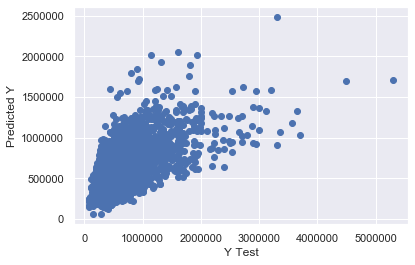

In [32]:
y4 = data['price']
X4 = data[['bathrooms','bedrooms','sqft_above','floors']]
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3, random_state=101)

lm = LinearRegression()
lm.fit(X4_train,y4_train)
print('Coefficients: \n', lm.coef_)

predictions = lm.predict(X4_test)
plt.scatter(y4_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

# calculate these metrics by hand!
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

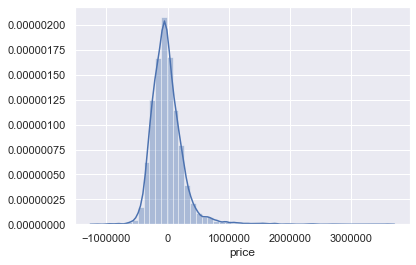

In [33]:
sns.distplot((y_test-predictions),bins=50)

# Data Visualization
Communicate the findings with key stakeholders using plots and interactive visualizations